In [59]:
import os
import cv2
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime


In [61]:
DATASET_PATH = "wiki_crop"
MAT_FILE = os.path.join(DATASET_PATH, "wiki.mat")

In [63]:
def load_data_from_mat():
    if not os.path.exists(MAT_FILE):
        raise FileNotFoundError(f"MAT file not found at: {MAT_FILE}")
    
    print("Loading .mat file...")
    mat = loadmat(MAT_FILE)
    data = mat["wiki"]

    image_paths = data[0, 0]["full_path"][0]
    dob = data[0, 0]["dob"][0]
    photo_taken = data[0, 0]["photo_taken"][0]
    gender = data[0, 0]["gender"][0]

    images = []
    ages = []
    genders = []

    root_folder = os.path.dirname(MAT_FILE)

    for i in range(len(image_paths)):
        try:
            path = os.path.join(root_folder, image_paths[i][0])
            if not os.path.exists(path):
                continue
            
            birth_matlab = dob[i]
            birth_date = datetime.fromordinal(int(birth_matlab)) if birth_matlab > 0 else None
            age = photo_taken[i] - birth_date.year if birth_date else None

            if age is None or age < 0 or age > 100:
                continue

            img = cv2.imread(path)
            if img is None:
                continue

            img = cv2.resize(img, (128, 128))
            images.append(img)
            ages.append(age)
            genders.append(int(gender[i]) if not np.isnan(gender[i]) else -1)

        except Exception as e:
            print(f"Error on {i}: {e}")
            continue

    print(f"Total samples loaded: {len(images)}")
    return np.array(images), np.array(ages), np.array(genders)


In [65]:
X, y_age, y_gender = load_data_from_mat()
print("X shape:", X.shape)
print("y_age shape:", y_age.shape)


Loading .mat file...
Total samples loaded: 59272
X shape: (59272, 128, 128, 3)
y_age shape: (59272,)


In [66]:
X_train, X_test, age_train, age_test, gender_train, gender_test = train_test_split(
    X, y_age, y_gender, test_size=0.2, random_state=42
)

In [69]:
def build_age_model():
    inputs = Input(shape=(128, 128, 3))
    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    age_output = Dense(1, name="age")(x)

    model = Model(inputs=inputs, outputs=age_output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [71]:
def build_gender_model():
    inputs = Input(shape=(128, 128, 3))
    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    gender_output = Dense(1, activation='sigmoid', name="gender")(x)

    model = Model(inputs=inputs, outputs=gender_output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [73]:
# Initialize and train the age model
age_model = build_age_model()
age_model.summary()

age_model.fit(X_train, age_train, validation_data=(X_test, age_test), epochs=10, batch_size=32)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ age (Dense)                          │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,337 (462.25 KB)

 Trainable params: 118,337 (462.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 346s 230ms/step - loss: 671.9925 - mae: 15.6403 - val_loss: 264.6579 - val_mae: 11.8988
Epoch 2/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 316s 213ms/step - loss: 250.3716 - mae: 12.0050 - val_loss: 228.2831 - val_mae: 11.6324
Epoch 3/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 306s 207ms/step - loss: 231.3048 - mae: 11.5212 - val_loss: 223.1051 - val_mae: 10.9075
Epoch 4/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 307s 207ms/step - loss: 212.0806 - mae: 11.0610 - val_loss: 225.5138 - val_mae: 10.7995
Epoch 5/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 306s 207ms/step - loss: 204.8867 - mae: 10.9109 - val_loss: 201.1646 - val_mae: 10.7495
Epoch 6/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 311s 210ms/step - loss: 203.0361 - mae: 10.8272 - val_loss: 209.4032 - val_mae: 10.6361
Epoch 7/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 305s 206ms/step - loss: 201.2303 - mae: 10.7718 - val_loss: 193.9235 - val_mae: 10.5400
Epoch 8/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 308s 208ms/step - loss: 193.4047 - mae: 10.5618 

In [74]:
age_test_loss, age_test_mae = age_model.evaluate(X_test, age_test)
print(f"Age Model Test Loss: {age_test_loss:.4f}")
print(f"Age Model Test MAE: {age_test_mae:.4f}")


371/371 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - loss: 193.0603 - mae: 10.2086
Age Model Test Loss: 192.6096
Age Model Test MAE: 10.2005


In [75]:
# Initialize and train the gender model
gender_model = build_gender_model()
gender_model.summary()

gender_model.fit(X_train, gender_train, validation_data=(X_test, gender_test), epochs=10, batch_size=32)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gender (Dense)                       │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,337 (462.25 KB)

 Trainable params: 118,337 (462.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 327s 219ms/step - accuracy: 0.7221 - loss: 1.1313 - val_accuracy: 0.7861 - val_loss: 0.5322
Epoch 2/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 320s 216ms/step - accuracy: 0.7792 - loss: 0.5384 - val_accuracy: 0.7981 - val_loss: 0.5089
Epoch 3/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 318s 215ms/step - accuracy: 0.7966 - loss: 0.5057 - val_accuracy: 0.8063 - val_loss: 0.4940
Epoch 4/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 314s 212ms/step - accuracy: 0.8080 - loss: 0.4874 - val_accuracy: 0.8065 - val_loss: 0.4941
Epoch 5/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 299s 201ms/step - accuracy: 0.8068 - loss: 0.4905 - val_accuracy: 0.8107 - val_loss: 0.5137
Epoch 6/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 302s 204ms/step - accuracy: 0.8064 - loss: 0.4814 - val_accuracy: 0.8165 - val_loss: 0.4714
Epoch 7/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 302s 204ms/step - accuracy: 0.8101 - loss: 0.4770 - val_accuracy: 0.8107 - val_loss: 0.4850
Epoch 8/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 310s 209ms/step - ac

In [76]:
gender_test_loss, gender_test_acc = gender_model.evaluate(X_test, gender_test)
print(f"Gender Model Test Loss: {gender_test_loss:.4f}")
print(f"Gender Model Test Accuracy: {gender_test_acc:.4f}")


371/371 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.8173 - loss: 0.4728
Gender Model Test Loss: 0.4712
Gender Model Test Accuracy: 0.8181


In [77]:
# Save the trained models
age_model.save("age_prediction_model.keras")
gender_model.save("gender_prediction_model.keras")


In [78]:
# Load models for inference
from tensorflow.keras.models import load_model
age_model = load_model("age_prediction_model.keras")
gender_model = load_model("gender_prediction_model.keras")




In [79]:
import cv2
def predict_age_and_gender(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return
    img = cv2.resize(img, (128, 128))
    img_input = img / 255.0  # Normalize
    img_input = np.expand_dims(img_input, axis=0)  # Add batch dimension

    # Predictions
    predicted_age = age_model.predict(img_input)[0][0]
    predicted_gender_prob = gender_model.predict(img_input)[0][0]
    predicted_gender = "Male" if predicted_gender_prob > 0.5 else "Female"

    print(f"Predicted Age: {int(predicted_age)}")
    print(f"Predicted Gender: {predicted_gender} (Confidence: {predicted_gender_prob:.2f})")

In [86]:
predict_age_and_gender("8699693_1983-10-05_2007.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Age: 30
Predicted Gender: Male (Confidence: 0.78)


371/371 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step


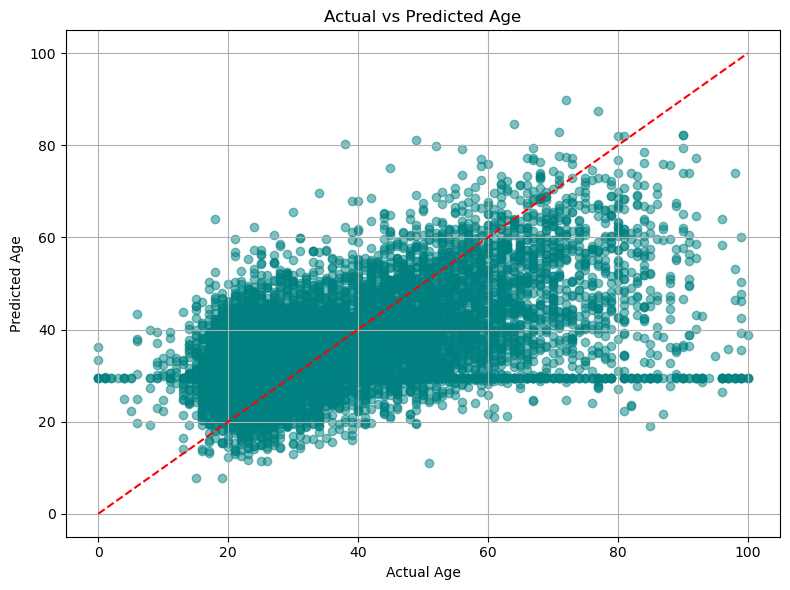

In [125]:
import matplotlib.pyplot as plt
age_preds = age_model.predict(X_test).flatten()

plt.figure(figsize=(8, 6))
plt.scatter(age_test, age_preds, alpha=0.5, color='teal')
plt.plot([age_test.min(), age_test.max()], [age_test.min(), age_test.max()], 'r--')
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Actual vs Predicted Age")
plt.grid(True)
plt.tight_layout()
plt.show()




In [131]:
age_history = age_model.fit(X_train, age_train, validation_data=(X_test, age_test), epochs=10, batch_size=32)
gender_history = gender_model.fit(X_train, gender_train, validation_data=(X_test, gender_test), epochs=10, batch_size=32)



Epoch 1/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 332s 222ms/step - loss: 187.7886 - mae: 10.3950 - val_loss: 193.1710 - val_mae: 10.1192
Epoch 2/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 314s 212ms/step - loss: 181.7455 - mae: 10.2335 - val_loss: 189.1544 - val_mae: 10.1829
Epoch 3/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 304s 205ms/step - loss: 183.1923 - mae: 10.2090 - val_loss: 196.3784 - val_mae: 10.3651
Epoch 4/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 309s 209ms/step - loss: 183.3800 - mae: 10.2408 - val_loss: 196.4008 - val_mae: 10.6498
Epoch 5/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 317s 214ms/step - loss: 183.0873 - mae: 10.1930 - val_loss: 207.4648 - val_mae: 10.4057
Epoch 6/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 317s 214ms/step - loss: 179.2196 - mae: 10.1254 - val_loss: 192.2046 - val_mae: 10.3270
Epoch 7/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 311s 210ms/step - loss: 175.6507 - mae: 10.0391 - val_loss: 191.5304 - val_mae: 10.3251
Epoch 8/10
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 318s 214ms/step - loss: 169.7911 - mae: 9.8567 -

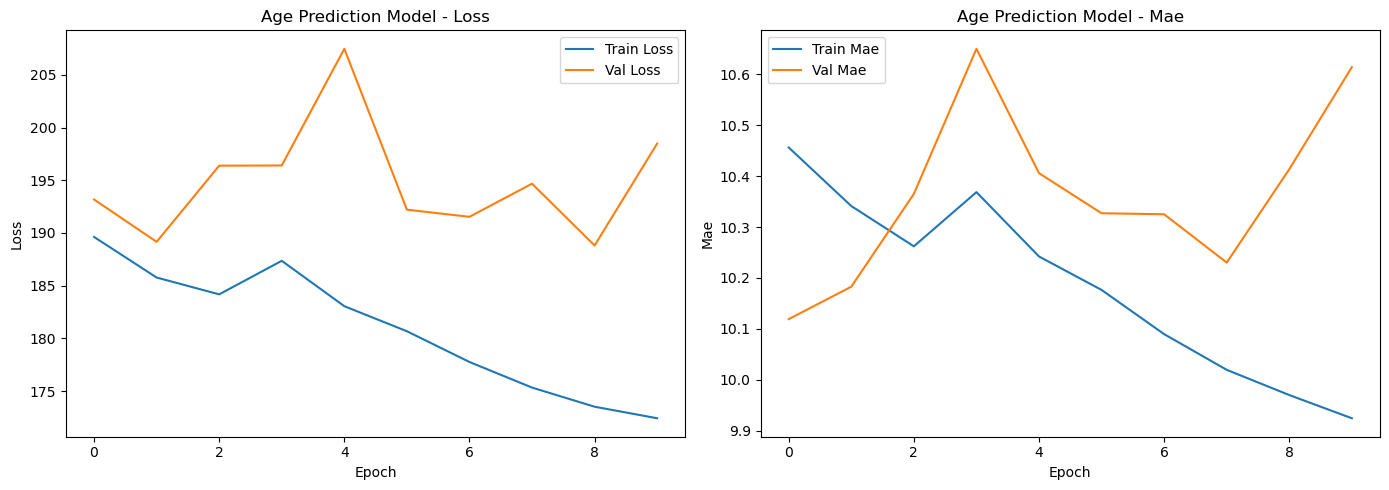

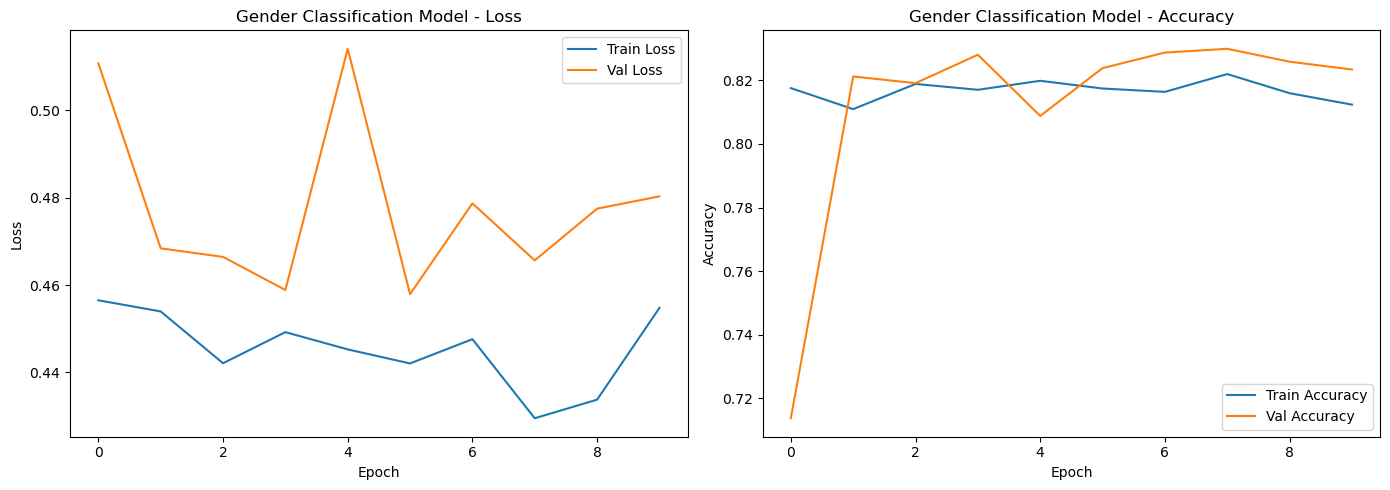

In [132]:
def plot_training_history(history, title="Model Training History"):
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title + " - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy / MAE
    plt.subplot(1, 2, 2)
    metric = 'mae' if 'mae' in history.history else 'accuracy'
    plt.plot(history.history[metric], label='Train ' + metric.capitalize())
    plt.plot(history.history['val_' + metric], label='Val ' + metric.capitalize())
    plt.title(title + " - " + metric.capitalize())
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for both models
plot_training_history(age_history, "Age Prediction Model")
plot_training_history(gender_history, "Gender Classification Model")


371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step


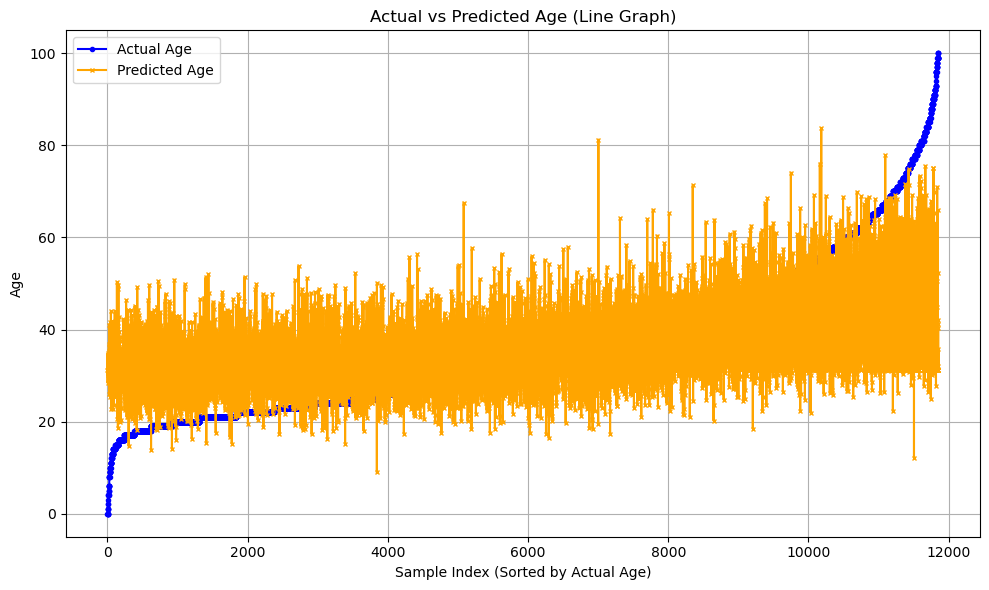

In [136]:
# Flatten predictions to 1D array if not already done
age_preds = age_model.predict(X_test).flatten()

# Sort the actual and predicted ages
sorted_indices = np.argsort(age_test)
sorted_age_test = age_test[sorted_indices]
sorted_age_preds = age_preds[sorted_indices]

# Plot line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_age_test, label="Actual Age", color='blue', linestyle='-', marker='o', markersize=3)
plt.plot(sorted_age_preds, label="Predicted Age", color='orange', linestyle='-', marker='x', markersize=3)

# Adding labels and title
plt.xlabel("Sample Index (Sorted by Actual Age)")
plt.ylabel("Age")
plt.title("Actual vs Predicted Age (Line Graph)")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def show_prediction(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image not found: {image_path}")
        return

    img_resized = cv2.resize(img, (128, 128))
    img_input = img_resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    # Predict
    age_pred = age_model.predict(img_input)[0][0]
    gender_pred = gender_model.predict(img_input)[0][0]
    gender_label = "Male" if gender_pred > 0.5 else "Female"

    # Draw on original image (not resized)
    display_img = img.copy()
    label = f"Age: {int(age_pred)}, Gender: {gender_label}"
    cv2.putText(display_img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("Prediction", display_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [57]:
show_prediction("8699693_1983-10-05_2007.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
